In [100]:
import pandas as pd 
import numpy as np 
import seaborn as sn
import re

# 1. Flowchart

## 1.1 Sujet non eligible à la randomisation 

In [103]:
# === 1. Charger les fichiers ===
dm1 = pd.read_csv("ascii-data-files nida-ctn-0001-20251024/dm.csv")   # Démographie
dm2 =pd.read_csv("ascii-data-files nida-ctn-0002-20251027/dm.csv")
ds1 = pd.read_csv("ascii-data-files nida-ctn-0001-20251024/ds.csv")   # Inclusion/Exclusion
ds2 = pd.read_csv("ascii-data-files nida-ctn-0002-20251027/ds.csv")   # Disposition (facultatif)

In [104]:
dm1.head(3)

,STUDYID,DOMAIN,USUBJID,EPOCH,VISIT,VISITNUM,RFSTDTC,RFENDTC,SITEID,BRTHDTC,AGE,AGEU,SEX,RACE,ETHNIC,ARMCD,ARM,COUNTRY,DMDTC,DMDY
0,NIDA-CTN-0001,DM,01_000579,SCREENING,"BASELINE, ANY DAY PRIOR TO FIRST DOSE",0,2001.0,2001.0,NaN,1974.0,27.282683094,YEARS,F,WHITE,NaN,CLON,CLONIDINE,USA,2001,-1
1,NIDA-CTN-0001,DM,01_001362,SCREENING,"BASELINE, ANY DAY PRIOR TO FIRST DOSE",0,2001.0,2001.0,NaN,1960.0,41.429158111,YEARS,F,"BLACK, AFRICAN AMERICAN, OR NEGRO",NaN,CLON,CLONIDINE,USA,2001,1
2,NIDA-CTN-0001,DM,01_001490,SCREENING,"BASELINE, ANY DAY PRIOR TO FIRST DOSE",0,2001.0,2001.0,NaN,1971.0,30.392881588,YEARS,M,WHITE,NaN,BUPNAL,BUPRENORPHINE/NALOXONE,USA,2001,-1


In [105]:
print(dm1["ARM"].value_counts())

ARM
BUPRENORPHINE/NALOXONE    77
CLONIDINE                 36
SCREEN FAILURE            25
Name: count, dtype: int64


In [106]:
print(dm2["ARM"].value_counts())

ARM
BUPRENORPHINE/NALOXONE    156
CLONIDINE                  74
SCREEN FAILURE             43
Name: count, dtype: int64


In [107]:
# Concaténation demographie
DM = pd.concat([dm1, dm2], ignore_index=True)

# Vérifier le nombre de  repartition par bras et compter le totale  
print(DM["ARM"].value_counts())
print("Total sujets DM :", DM.shape[0])

ARM
BUPRENORPHINE/NALOXONE    233
CLONIDINE                 110
SCREEN FAILURE             68
Name: count, dtype: int64
Total sujets DM : 411


In [108]:
# Restreint DM aux seuls patients randomisés dans les 2 bras de traitement
DM= DM[DM["ARM"].isin(["BUPRENORPHINE/NALOXONE", "CLONIDINE"])]
print("Total sujets randomizer :", DM.shape[0])

Total sujets randomizer : 343


## 1.2 Sujet ayant abondonner dans la phase active ( Study day & follow up ) 

In [109]:
# Concaténation disposition
DS = pd.concat([ds1, ds2], ignore_index=True)

In [110]:
# Étape 1 : garder seulement la phase active (on exclut SCREENING)
DS_active = DS[DS["EPOCH"] != "SCREENING"]

# Étape 2 : identifier les événements avant la fin de la phase active (VISITNUM < 14)
DS_active = DS_active[DS_active["VISITNUM"] < 14]

# Étape 3 : exclure ceux qui ont terminé la phase active
DS_disc = DS_active[
    DS_active["DSDECOD"] != "PARTICIPANT COMPLETED ACTIVE PHASE OF STUDY"
]

# Étape 4 : joindre avec DM randomisé pour récupérer le bras ARM
DS_disc = DS_disc.merge(
    DM[["USUBJID", "ARM"]],
    on="USUBJID",
    how="inner"
)

# Étape 5 : compter les discontinuations par bras
discontinuations_by_arm = DS_disc["ARM"].value_counts()

print("===== Discontinuations par bras =====")
print(discontinuations_by_arm)

===== Discontinuations par bras =====
ARM
CLONIDINE                 31
BUPRENORPHINE/NALOXONE    26
Name: count, dtype: int64


In [111]:
# Étape 1 : garder seulement les visites de follow-up (VISITNUM ≥ 15)
DS_fu = DS[DS["VISITNUM"] > 14]

# Étape 2 : exclure ceux qui ont terminé la phase active
DS_fu_abandoned = DS_fu[
    DS_fu["DSDECOD"] != "PARTICIPANT COMPLETED ACTIVE PHASE OF STUDY"
]

# Étape 3 : garder une seule ligne par patient
DS_fu_abandoned = DS_fu_abandoned.drop_duplicates(subset=["USUBJID"])

# Étape 4 : joindre avec DM randomisé pour récupérer ARM
DS_fu_abandoned = DS_fu_abandoned.merge(
    DM[["USUBJID", "ARM"]],
    on="USUBJID",
    how="inner"
)

# Étape 5 : compter les abandons de follow-up par bras
followup_abandon_by_arm = DS_fu_abandoned["ARM"].value_counts()

print("===== Abandon du suivi (follow-up) par bras =====")
print(followup_abandon_by_arm)


===== Abandon du suivi (follow-up) par bras =====
ARM
BUPRENORPHINE/NALOXONE    95
CLONIDINE                 60
Name: count, dtype: int64


## 1.3 Analyse en intention de traiter (ITT ) 

In [112]:
# Effet du traitement dans des conditions réelles, incluant les écarts au protocole.
# La seule condition : avoir été randomisé.

# Afficher l'effectif par bras (ITT = tous les randomisés)
print("===== ITT (nombre de patients par bras) =====")
print(DM["ARM"].value_counts())

===== ITT (nombre de patients par bras) =====
ARM
BUPRENORPHINE/NALOXONE    233
CLONIDINE                 110
Name: count, dtype: int64


## 1.4 Analyse Per Protocol (PP)

In [113]:
# On analyse seulement ceux qui ont réellement suivi le protocole prévu.
# ITT = tous les patients dans DM (déjà filtré sur les 2 bras)
itt_counts = DM["ARM"].value_counts()

# Nombre de discontinuations par bras (DS_disc)
disc_counts = DS_disc["ARM"].value_counts()

# On inclu pas lost to follow up car le traitement actif est terminé → protocole respecté.

# Calcul du Per Protocol
pp_counts = itt_counts - disc_counts

print("===== Population Per Protocol (PP) =====")
print(pp_counts)


===== Population Per Protocol (PP) =====
ARM
BUPRENORPHINE/NALOXONE    207
CLONIDINE                  79
Name: count, dtype: int64


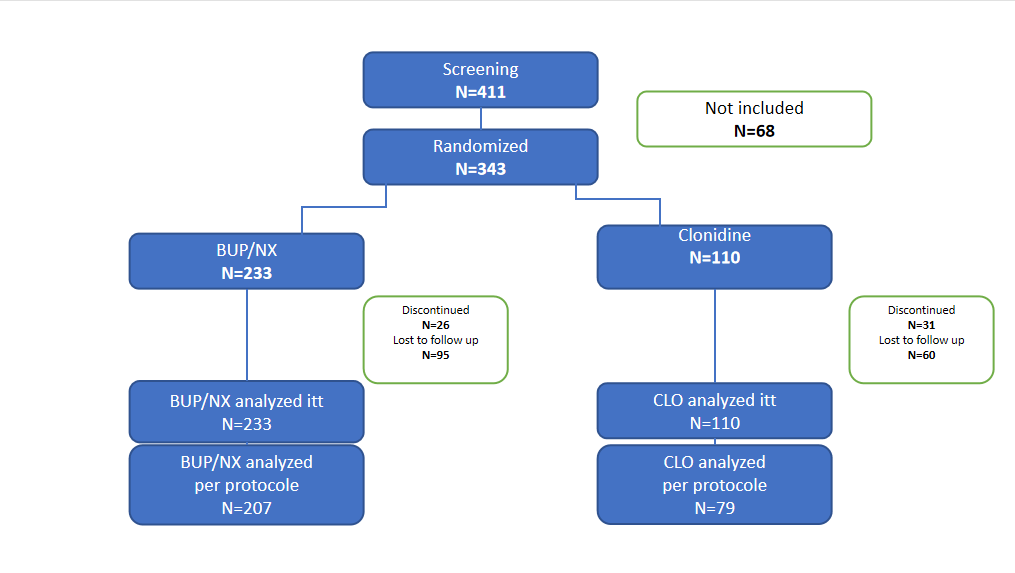